In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
import cv2
from collections import deque
import time
import pickle

In [2]:
%matplotlib inline

In [ ]:
# image(BGR) -> image(HSL) -> resize -> LCE -> FF
# 
# input: same training set and test set
# output:
# 1. resized HSL image -> random forest
# 2. resized HSL LCE image -> random forest
# 3. resized HSL FF image -> random forest
# 4. resized HSL LCE FF image -> random forest

In [10]:
def PHI_W(f, patch_mean, patch_var):
    return 1 / (1 + np.exp((patch_mean - f) / (patch_var ** 0.5)))

def local_contrast_enhancement(input_image, patch_size, color_scale, var_threshold):
    """ local contrast enhancement """
    """ color_scale is the scale of value in each dimension, if [0, 1], input 1; if [0, 255]. input 255 """
    f_min = np.amin(input_image[:, :, 1])
    f_max = np.amax(input_image[:, :, 1])
    res_pic = np.copy(input_image)
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            if (res_pic[i][j][1] == 0):
                continue
            start_pos_i = i - int(patch_size / 2)
            start_pos_j = j - int(patch_size / 2)
            end_pos_i = start_pos_i + patch_size
            end_pos_j = start_pos_j + patch_size
            start_pos_i = max(0, start_pos_i)
            start_pos_j = max(0, start_pos_j)
            end_pos_i = min(input_image.shape[0], end_pos_i)
            end_pos_j = min(input_image.shape[1], end_pos_j)
            patch_mean = input_image[start_pos_i: end_pos_i, start_pos_j : end_pos_j, 1].mean()
            patch_var = input_image[start_pos_i: end_pos_i, start_pos_j : end_pos_j, 1].var()
            if patch_var < var_threshold:
                continue
            res_pic[i][j][1] = color_scale * ((PHI_W(input_image[i][j][1], patch_mean, patch_var) - PHI_W(f_min, patch_mean, patch_var)) / (PHI_W(f_max, patch_mean, patch_var) - PHI_W(f_min, patch_mean, patch_var)))

    return res_pic

In [11]:
def flood_fill_hls(input_image, threshold):
    segment_counter = 0
    segment_res = np.zeros((input_image.shape[0], input_image.shape[1]), dtype=np.uint64)
    color_mean = []
    #debug
    #print segment_res.shape
    #covered_pixel = 0
    #debug
    direction = [(0, -1), (0, 1), (1, 0), (-1, 0)]
    x = input_image.shape[0]
    y = input_image.shape[1]
    
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            if (segment_res[i][j] == 0):
                queue_list = deque([(i, j)])
                segment_counter = segment_counter + 1
                segment_res[i][j] = segment_counter
                #regeion_color0 = [input_image[i][j][0]]
                #regeion_color1 = [input_image[i][j][1]]
                #regeion_color2 = [input_image[i][j][2]]
                c0_sum = long(input_image[i][j][0])
                c0_num = long(1)
                c1_sum = long(input_image[i][j][1])
                c1_num = long(1)
                c2_sum = long(input_image[i][j][2])
                c2_num = long(1)
                #while (len(queue_list) > 0):
                #start = time.time()
                while queue_list:
                    center_i, center_j = queue_list.popleft()
                    #center_i = queue_list[0][0]
                    #center_j = queue_list[0][1]
                    #for new_i in range(center_i - 1, center_i + 2):
                        #for new_j in range(center_j - 1, center_j + 2):
                    for dirc in direction:
                        new_i = center_i + dirc[0]
                        new_j = center_j + dirc[1]
                        if (new_i >= 0 and new_i < x and new_j >= 0 and new_j < y and segment_res[new_i][new_j] == 0):
                            h_1 = input_image[center_i][center_j][0]
                            h_2 = input_image[new_i][new_j][0]
                            h_max = max(h_1, h_2)
                            h_min = min(h_1, h_2)
                            delta0 = min(h_max-h_min, 180+h_min-h_max) / 180
                            delta1 = (input_image[center_i][center_j][1] - input_image[new_i][new_j][1]) / 255
                            delta2 = (input_image[center_i][center_j][2] - input_image[new_i][new_j][2]) / 255
                            color_distance = (delta0 ** 2) + (delta1 ** 2) + (delta2 ** 2)
                            if (color_distance <= threshold):
                                queue_list.append((new_i, new_j))
                                segment_res[new_i][new_j] = segment_counter
                                #regeion_color0.append(input_image[new_i][new_j][0])
                                #regeion_color1.append(input_image[new_i][new_j][1])
                                #regeion_color2.append(input_image[new_i][new_j][2])
                                c0_sum += input_image[new_i][new_j][0]
                                c0_num += 1
                                c1_sum += input_image[new_i][new_j][1]
                                c1_num += 1
                                c2_sum += input_image[new_i][new_j][2]
                                c2_num += 1
                                #
                                #covered_pixel = covered_pixel + 1
                                #
                    #queue_list.popleft()
                #print "1",time.time() - start
                #start = time.time()
                #color_mean.append((pd.Series(regeion_color0).median(), pd.Series(regeion_color1).median(), pd.Series(regeion_color2).median()))
                #color_mean.append((int(np.array(regeion_color0).mean()), int(np.array(regeion_color1).mean()), int(np.array(regeion_color2).mean())))
                color_mean.append((int(c0_sum/c0_num), int(c1_sum/c1_num), int(c2_sum/c2_num)))
                #print "2",time.time() - start

    res_pic = np.zeros(input_image.shape, dtype = np.uint8)
    for i in range(x):
        for j in range(y):
            res_pic[i][j][0] = color_mean[int(segment_res[i][j] - 1)][0]
            res_pic[i][j][1] = color_mean[int(segment_res[i][j] - 1)][1]
            res_pic[i][j][2] = color_mean[int(segment_res[i][j] - 1)][2]

    #return segment_res, res_pic, segment_counter
    return res_pic

In [33]:
def gen_train_test(df, num=200):
    # put image names into one of 5 buckets according to their levels
    level_list = [[] for i in range(5)] # 5 levels
    for i in range(len(df)):
        level_list[df.iloc[i]['level']].append(df.iloc[i]['image'])
    
    # pick 5*num random image names for training set and test set
    X_train_label = [[] for i in range(5)]
    X_test_label = [[] for i in range(5)]
    for i in range(5):
        index = np.random.permutation(len(level_list[i]))
        for j in index[0:num]:
            X_train_label[i].append(level_list[i][j])
        for j in index[num:num*2]:
            X_test_label[i].append(level_list[i][j])
            
    pickle.dump(X_train_label, open("X_train_label", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(X_test_label, open("X_test_label", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print "X label dump done."
    
    # load actual image binary according to label lists 
    # training set
    X_train = np.nan
    y_train = []
    for i in range(5):
        for name in X_train_label[i]:
            tmp = cv2.imread("../../train256/"+name+".jpeg")
            tmp = cv2.resize(tmp, (256,171))
            tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2HLS)
            #tmp = local_contrast_enhancement(tmp, 50, 179, 30)
            #tmp = flood_fill_hls(tmp, 0.8)
            tmp = tmp.reshape((1, 171*256*3))
            """
            img = cv2.imread("../../train256/16_right.jpeg")
            img = cv2.resize(img, (256,171))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            img = local_contrast_enhancement(img, 50, 179, 30)
            img = flood_fill_hls(img, 0.8)
            """
            if X_train is np.nan:
                X_train = tmp
            else:
                X_train = np.concatenate((X_train, tmp), axis=0)
            y_train.append(i)
    y_train = np.array(y_train)
    
    pickle.dump(X_train, open("X_train", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_train, open("y_train", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print "X_train and y_train dump done."
    
    # test set
    X_test = np.nan
    y_test = []
    for i in range(5):
        for name in X_test_label[i]:
            tmp = cv2.imread("../../train256/"+name+".jpeg")
            tmp = cv2.resize(tmp, (256,171))
            tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2HLS)
            #tmp = local_contrast_enhancement(tmp, 50, 179, 30)
            #tmp = flood_fill_hls(tmp, 0.8)
            tmp = tmp.reshape((1, 171*256*3))
            if X_test is np.nan:
                X_test = tmp
            else:
                X_test = np.concatenate((X_test, tmp), axis=0)
            y_test.append(i)
    y_test = np.array(y_test)
    
    pickle.dump(X_test, open("X_test", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_test, open("y_test", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print "X_test and y_test dump done."
    
    return X_train,y_train,X_test,y_test,X_train_label,X_test_label



In [59]:
def dump_LCE():
    X_train = np.nan
    train = pickle.load(open("X_train", 'rb'))
    for i in train:
        tmp = i.reshape((171,256,3))
        tmp = local_contrast_enhancement(tmp, 50, 179, 30)
        tmp = tmp.reshape((1, 171*256*3))
        if X_train is np.nan:
            X_train = tmp
        else:
            X_train = np.concatenate((X_train, tmp), axis=0)
    pickle.dump(X_train, open("X_train_lce", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print "X_train_lce done."
    
    X_test = np.nan
    test = pickle.load(open("X_test", 'rb'))
    for i in test:
        tmp = i.reshape((171,256,3))
        tmp = local_contrast_enhancement(tmp, 50, 179, 30)
        tmp = tmp.reshape((1, 171*256*3))
        if X_test is np.nan:
            X_test = tmp
        else:
            X_test = np.concatenate((X_test, tmp), axis=0)
    pickle.dump(X_test, open("X_test_lce", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print "X_test_lce done."

In [61]:
def dump_LCE_FF():
    X_train = np.nan
    train = pickle.load(open("X_train", 'rb'))
    for i in train:
        tmp = i.reshape((171,256,3))
        tmp = local_contrast_enhancement(tmp, 50, 179, 30)
        tmp = flood_fill_hls(tmp, 0.8)
        tmp = tmp.reshape((1, 171*256*3))
        if X_train is np.nan:
            X_train = tmp
        else:
            X_train = np.concatenate((X_train, tmp), axis=0)
    pickle.dump(X_train, open("X_train_lce_ff", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print "X_train_lce_ff done."
    
    X_test = np.nan
    test = pickle.load(open("X_test", 'rb'))
    for i in test:
        tmp = i.reshape((171,256,3))
        tmp = local_contrast_enhancement(tmp, 50, 179, 30)
        tmp = flood_fill_hls(tmp, 0.8)
        tmp = tmp.reshape((1, 171*256*3))
        if X_test is np.nan:
            X_test = tmp
        else:
            X_test = np.concatenate((X_test, tmp), axis=0)
    pickle.dump(X_test, open("X_test_lce_ff", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print "X_test_lce_ff done."

In [13]:
def random_forest_test(n_estimators, criterion, max_depth, X_train, y_train, X_test, y_test):
    rf = ensemble.RandomForestClassifier(n_estimators = n_estimators, criterion=criterion, max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    """
    # Compute confusion matrix
    print "n_estimators =",n_estimators
    print "criterion =",criterion
    print "max_depth =",max_depth
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    cm_df = pd.DataFrame(cm)
    cm_df.columns.name = 'Predict label'
    cm_df.index.name = 'True label'
    print cm_df
    """
    test_score = rf.score(X_test, y_test)
    train_score = rf.score(X_train, y_train)
    print "n_estimators =",n_estimators,"criterion =",criterion,"max_depth =",max_depth,"test_score =",test_score,"train_score =",train_score
    return test_score, train_score

In [26]:
df = pd.read_csv("../../trainLabels.csv")



In [34]:
t = time.time()
X_train,y_train,X_test,y_test,X_train_label,X_test_label = gen_train_test(df, 200)
print time.time()-t


X label dump done.
X_train and y_train dump done.
X_test and y_test dump done.
111.310882807


In [60]:
t = time.time()
dump_LCE()
print time.time()-t

X_train_lce done.
X_test_lce done.
4397.92149615


In [62]:
t = time.time()
dump_LCE_FF()
print time.time()-t

X_train_lce_ff done.
X_test_lce_ff done.
9489.74861598


In [67]:
d = {1:2, 2:3, 3:4}
max(d.items(), key = lambda d: d[1])

(3, 4)

In [168]:
random_forest_test(500, "gini", 7, X_train, y_train, X_test, y_test)



n_estimators = 500 criterion = gini max_depth = 7 test_score = 0.289 train_score = 0.993


(0.28899999999999998, 0.99299999999999999)

In [167]:
test_result = dict()
train_result = dict()
n_estimators = [10, 50, 100, 200, 500, 750]
criterion = ["gini", "entropy"]
max_depth = [5, 6, 7, 8, 9, 10]

for n in n_estimators:
    for c in criterion:
        for d in max_depth:
            test_score, train_score = random_forest_test(n, c, d, X_train, y_train, X_test, y_test)
            test_result[(n,c,d)] = test_score
            train_result[(n,c,d)] = train_score

n_estimators = 10 criterion = gini max_depth = 5 test_score = 0.252 train_score = 0.631
n_estimators = 10 criterion = gini max_depth = 6 test_score = 0.247 train_score = 0.689
n_estimators = 10 criterion = gini max_depth = 7 test_score = 0.264 train_score = 0.802
n_estimators = 10 criterion = gini max_depth = 8 test_score = 0.252 train_score = 0.802
n_estimators = 10 criterion = gini max_depth = 9 test_score = 0.273 train_score = 0.873
n_estimators = 10 criterion = gini max_depth = 10 test_score = 0.238 train_score = 0.911
n_estimators = 10 criterion = entropy max_depth = 5 test_score = 0.263 train_score = 0.64
n_estimators = 10 criterion = entropy max_depth = 6 test_score = 0.243 train_score = 0.756
n_estimators = 10 criterion = entropy max_depth = 7 test_score = 0.253 train_score = 0.87
n_estimators = 10 criterion = entropy max_depth = 8 test_score = 0.246 train_score = 0.901
n_estimators = 10 criterion = entropy max_depth = 9 test_score = 0.275 train_score = 0.937
n_estimators = 10 

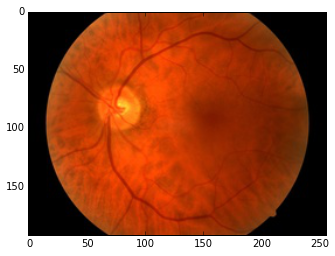

In [159]:
img = plt.imread("../../train256/37569_left.jpeg")
plt.imshow(img)
plt.show()

(171, 256, 3)
(171, 256, 3)
0.00244808197021


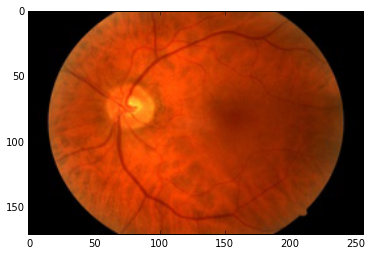

In [42]:
start = time.time()
img = cv2.imread("../../train256/37569_left.jpeg")
img = cv2.resize(img, (256,171))
print img.shape
img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
#img = local_contrast_enhancement(img, 50, 179, 30)
#img = flood_fill_hls(img, 0.8)
img.reshape((1, 171*256*3))
print img.shape
print time.time() - start
img = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
plt.imshow(img)
plt.show()



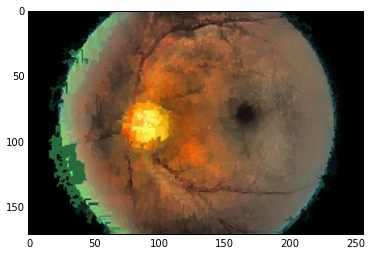

In [162]:
tmp = X_train[0]
tmp = tmp.reshape((171,256,3))
tmp = cv2.cvtColor(tmp, cv2.COLOR_HLS2RGB)
plt.imshow(tmp)
plt.show()


In [151]:
y_train[2]




2

In [158]:
X_train_label[0]

['37569_left']

In [6]:
y = []
for i in range(len(df)):
    y.append(df.iloc[i]['level'])
n,b,p = plt.hist(y, bins=[0,1,2,3,4,5])
plt.show()
print n
print n.sum()
print len(df)

[ 25810.   2443.   5292.    873.    708.]
35126.0
35126


In [70]:
s = []
for i in range(len(df)):
    tmp = plt.imread("../../train256/"+df.iloc[i]['image']+".jpeg")
    if tmp.shape != (171, 256, 3):
        print df.iloc[i]['image'],tmp.shape
    s.append(tmp.shape)


13_left (192, 256, 3)
13_right (192, 256, 3)
15_left (170, 256, 3)
15_right (170, 256, 3)
22_left (192, 256, 3)
22_right (192, 256, 3)
30_left (192, 256, 3)
30_right (192, 256, 3)
31_left (170, 256, 3)
31_right (170, 256, 3)
33_left (170, 256, 3)
33_right (170, 256, 3)
36_left (192, 256, 3)
36_right (192, 256, 3)
47_left (192, 256, 3)
47_right (192, 256, 3)
57_left (192, 256, 3)
57_right (192, 256, 3)
58_left (192, 256, 3)
58_right (192, 256, 3)
62_left (192, 256, 3)
62_right (192, 256, 3)
65_left (192, 256, 3)
65_right (192, 256, 3)
66_left (192, 256, 3)
66_right (192, 256, 3)
70_left (192, 256, 3)
70_right (192, 256, 3)
72_left (169, 256, 3)
72_right (169, 256, 3)
82_left (192, 256, 3)
82_right (192, 256, 3)
84_left (192, 256, 3)
84_right (192, 256, 3)
99_left (192, 256, 3)
99_right (192, 256, 3)
104_left (192, 256, 3)
104_right (192, 256, 3)
115_left (192, 256, 3)
115_right (192, 256, 3)
122_left (192, 256, 3)
122_right (192, 256, 3)
140_left (170, 256, 3)
140_right (170, 256, 3)
14

In [7]:
list_size0 = pd.Series([i[0] for i in s])
list_size0.max()
#plt.hist(list_size0, bins = 3)
#plt.show()

NameError: name 's' is not defined

In [11]:
level_list = [[] for i in range(5)]
for i in range(len(df)):
    level_list[df.iloc[i]['level']].append(df.iloc[i]['image'])

In [12]:
X_train_label = [[] for i in range(5)]
X_test_label = [[] for i in range(5)]
for i in range(5):
    index = np.random.permutation(len(level_list[i]))
    for j in index[0:200]:
        X_train_label[i].append(level_list[i][j])
    for j in index[200:400]:
        X_test_label[i].append(level_list[i][j])

In [14]:
X_train = np.nan
y_train = []
for i in range(5):
    for name in X_train_label[i]:
        tmp = plt.imread("../../train256/"+name+".jpeg")
        tmp_ = cv2.resize(tmp, (256,171))
        tmp_hls = cv2.cvtColor(tmp_, cv2.COLOR_BGR2HLS)
        tmp_lce = local_contrast_enhancement(tmp_hls, 25, 255, 30)
        tmp_ = tmp_lce.reshape((1, 171*256*3))
        if X_train is np.nan:
            X_train = tmp_
        else:
            X_train = np.concatenate((X_train, tmp_), axis=0)
        y_train.append(i)
y_train = np.array(y_train)

In [15]:
X_test = np.nan
y_test = []
for i in range(5):
    for name in X_test_label[i]:
        tmp = plt.imread("../../train256/"+name+".jpeg")
        tmp_ = cv2.resize(tmp, (256,171))
        tmp_hls = cv2.cvtColor(tmp_, cv2.COLOR_BGR2HLS)
        tmp_lce = local_contrast_enhancement(tmp_hls, 25, 255, 30)
        tmp_ = tmp_lce.reshape((1, 171*256*3))
        if X_test is np.nan:
            X_test = tmp_
        else:
            X_test = np.concatenate((X_test, tmp_), axis=0)
        y_test.append(i)
y_test = np.array(y_test)

In [20]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [63]:
"""
n = len(df)
samples = {}
X_train = np.nan
y_train = []
i = 0
count = [0] * 5
while i < 1000:
    index = np.random.randint(0, n)
    tmp = plt.imread("../../train256/"+df.iloc[index]['image']+".jpeg")
    tmp_name = df.iloc[index]['image']
    tmp_level = df.iloc[index]['level']
    if (count[tmp_level-1] <= 200) and (tmp.shape == (171, 256, 3)) and (tmp_name not in samples):
        samples[tmp_name] = tmp_level
        tmp = tmp.reshape((1, 171*256*3))
        if X_train is np.nan:
            X_train = tmp
        else:
            X_train = np.concatenate((X_train, tmp), axis=0)
        y_train.append(tmp_level)
        i += 1
        count[tmp_level-1] += 1
y_train = np.array(y_train)
"""

In [65]:
"""
n = len(df)
tests = {}
X_test = np.nan
y_test = []
i = 0
count = [0] * 5
while i < 1000:
    index = np.random.randint(0, n)
    tmp = plt.imread("../../train256/"+df.iloc[index]['image']+".jpeg")
    tmp_name = df.iloc[index]['image']
    tmp_level = df.iloc[index]['level']
    if (count[tmp_level-1] <= 200) and (tmp.shape == (171, 256, 3)) and (tmp_name not in samples) and (tmp_name not in tests):
        tests[tmp_name] = tmp_level
        tmp = tmp.reshape((1, 171*256*3))
        if X_test is np.nan:
            X_test = tmp
        else:
            X_test = np.concatenate((X_test, tmp), axis=0)
        y_test.append(tmp_level)
        i += 1
        count[tmp_level-1] += 1
y_test = np.array(y_test)
"""

In [147]:
def random_forest_test(n_estimators, criterion, max_depth):
    rf = ensemble.RandomForestClassifier(n_estimators = n_estimators, criterion=criterion, max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    """
    # Compute confusion matrix
    print "n_estimators =",n_estimators
    print "criterion =",criterion
    print "max_depth =",max_depth
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    cm_df = pd.DataFrame(cm)
    cm_df.columns.name = 'Predict label'
    cm_df.index.name = 'True label'
    print cm_df
    """
    test_score = rf.score(X_test, y_test)
    train_score = rf.score(X_train, y_train)
    print "n_estimators=",n_estimators,"criterion",criterion,"max_depth",max_depth,"test_score =",test_score,"train_score =",train_score
    return test_score, train_score
    

In [148]:
test_result = dict()
train_result = dict()
n_estimators = [10, 50, 100, 200, 500]
criterion = ["gini", "entropy"]
max_depth = [5, 6, 7, 8, 9, 10]

for n in n_estimators:
    for c in criterion:
        for d in max_depth:
            test_score, train_score = random_forest_test(n_estimators=n, criterion=c, max_depth=d)
            test_result[(n,c,d)] = test_score
            train_result[(n,c,d)] = train_score
            

test_score = 0.242 train_score = 0.507
test_score = 0.256 train_score = 0.644
test_score = 0.245 train_score = 0.685
test_score = 0.23 train_score = 0.781
test_score = 0.232 train_score = 0.817
test_score = 0.284 train_score = 0.881
test_score = 0.244 train_score = 0.56
test_score = 0.26 train_score = 0.693
test_score = 0.263 train_score = 0.724
test_score = 0.242 train_score = 0.807
test_score = 0.239 train_score = 0.857
test_score = 0.242 train_score = 0.885
test_score = 0.268 train_score = 0.671
test_score = 0.275 train_score = 0.772
test_score = 0.24 train_score = 0.889
test_score = 0.265 train_score = 0.903
test_score = 0.288 train_score = 0.933
test_score = 0.264 train_score = 0.982
test_score = 0.272 train_score = 0.741
test_score = 0.261 train_score = 0.828
test_score = 0.258 train_score = 0.909
test_score = 0.251 train_score = 0.958
test_score = 0.243 train_score = 0.977
test_score = 0.264 train_score = 0.998
test_score = 0.264 train_score = 0.721
test_score = 0.261 train_scor

In [122]:
rf = ensemble.RandomForestClassifier(n_estimators=500, max_depth=6, n_jobs=-1)

In [123]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0)

In [124]:
y_pred = rf.predict(X_test)

In [129]:
y_pred

array([1, 3, 3, 1, 0, 0, 3, 1, 3, 1, 1, 0, 3, 0, 3, 4, 3, 0, 4, 0, 1, 1, 2,
       4, 2, 0, 2, 1, 0, 0, 2, 1, 1, 2, 0, 4, 0, 1, 1, 0, 4, 1, 2, 3, 0, 1,
       3, 4, 3, 1, 3, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 3, 0, 0, 1,
       0, 0, 3, 0, 1, 4, 0, 4, 0, 1, 2, 0, 0, 4, 1, 2, 2, 1, 0, 2, 3, 3, 1,
       1, 1, 2, 0, 0, 3, 2, 2, 1, 4, 1, 0, 1, 4, 0, 0, 0, 1, 0, 1, 2, 0, 3,
       1, 3, 1, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 2, 4, 3, 2, 3, 0, 0,
       0, 2, 1, 1, 0, 0, 3, 2, 4, 2, 3, 2, 2, 0, 0, 2, 2, 3, 1, 2, 2, 0, 0,
       4, 0, 0, 0, 0, 1, 0, 2, 2, 0, 3, 4, 2, 0, 3, 0, 3, 4, 2, 2, 1, 1, 2,
       1, 0, 3, 3, 0, 0, 2, 1, 1, 1, 0, 3, 0, 2, 1, 3, 2, 0, 3, 1, 2, 3, 2,
       1, 2, 3, 0, 1, 4, 0, 3, 2, 0, 1, 0, 4, 2, 0, 4, 1, 0, 1, 0, 1, 3, 2,
       0, 3, 1, 0, 3, 2, 4, 0, 4, 1, 2, 1, 0, 1, 2, 1, 3, 4, 3, 3, 0, 2, 4,
       2, 1, 4, 3, 3, 2, 1, 4, 2, 2, 0, 3, 0, 1, 2, 4, 4, 0, 1, 2, 2, 0, 1,
       1, 3, 1, 2, 3, 3, 3, 1, 3, 4, 2, 0, 3, 2, 4, 1, 2, 1, 4, 3, 1, 0, 3,
       0, 0,

In [125]:
rf.score(X_test, y_test)

0.28799999999999998

In [140]:
rf.score(X_train, y_train)

1.0

In [130]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(1000)
    plt.xticks(tick_marks, "", rotation=45)
    plt.yticks(tick_marks, "")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [139]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_df = pd.DataFrame(cm)
cm_df.columns.name = 'Predict label'
cm_df.index.name = 'True label'
print cm_df

Predict label   0   1   2   3   4
True label                       
0              67  45  38  34  16
1              45  54  40  32  29
2              33  38  42  52  35
3              31  34  29  65  41
4              33  38  28  41  60


In [144]:
X_train.shape

(1000, 131328)

In [145]:
y_train.shape

(1000,)

In [149]:
X_test.shape

(1000, 131328)

In [150]:
y_test.shape

(1000,)

In [153]:
y_test

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 2, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 2, 0, 2, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 1, 4, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 3, 0, 4, 0, 0, 1, 2, 0, 0, 4, 0,
       4, 0, 0, 0, 0, 0, 3, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 4,
       0, 2, 3, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 4,
       0, 0,

In [12]:
plt.hist(y_train)
plt.show()

In [13]:
plt.hist(y_test)
plt.show()

In [46]:
def cosine(alpha, item):
    print "alpha =",alpha
    alpha_2 = alpha ** 2
    if item == "A":
        print "A and B:",(2 + 12 * alpha_2) / np.sqrt(9+120*alpha_2+144*alpha_2*alpha_2)
        print "A and C:",(4 * alpha_2) / np.sqrt(6+20*alpha_2+16*alpha_2*alpha_2)
    elif item == "B":
        print "B and A:",(2 + 12 * alpha_2) / np.sqrt(9+120*alpha_2+144*alpha_2*alpha_2)
        print "B and C:",(1 + 12 * alpha_2) / np.sqrt(6+84*alpha_2+144*alpha_2*alpha_2)
    elif item == "C":
        print "C and B:",(1 + 12 * alpha_2) / np.sqrt(6+84*alpha_2+144*alpha_2*alpha_2)
        print "C and A:",(4 * alpha_2) / np.sqrt(6+20*alpha_2+16*alpha_2*alpha_2)

In [56]:
cosine(1, 'C')
cosine(2, 'B')
cosine(0.5, 'B')
cosine(0, 'C')

alpha = 1
C and B: 0.849836585599
C and A: 0.617213399848
alpha = 2
B and A: 0.946094540761
B and C: 0.952579344416
alpha = 0.5
B and A: 0.721687836487
B and C: 0.666666666667
alpha = 0
C and B: 0.408248290464
C and A: 0.0


In [34]:
alpha = 1
print "alpha =",alpha
alpha_2 = alpha ** 2
# B and A
print "B and A:",(2 + 12 * alpha_2) / np.sqrt(9+120*alpha_2+144*alpha_2*alpha_2)
# B and C
print "B and C:",(1 + 12 * alpha_2) / np.sqrt(6+84*alpha_2+144*alpha_2*alpha_2)

alpha = 1
B and A: 0.847318545736
B and C: 0.849836585599


In [45]:
alpha = 0
print "alpha =",alpha
alpha_2 = alpha ** 2
# B and A
print "B and A:",(2 + 12 * alpha_2) / np.sqrt(9+120*alpha_2+144*alpha_2*alpha_2)
# B and C
print "B and C:",(1 + 12 * alpha_2) / np.sqrt(6+84*alpha_2+144*alpha_2*alpha_2)

alpha = 0
B and A: 0.666666666667
B and C: 0.408248290464


In [44]:
alpha = 0.5
print "alpha =",alpha
alpha_2 = alpha ** 2
# A and B
print "A and B:",(2 + 12 * alpha_2) / np.sqrt(9+120*alpha_2+144*alpha_2*alpha_2)
# A and C
print "A and C:",(4 * alpha_2) / np.sqrt(6+20*alpha_2+16*alpha_2*alpha_2)

alpha = 0.5
A and B: 0.721687836487
A and C: 0.288675134595


In [43]:
alpha = 1
print "alpha =",alpha
alpha_2 = alpha ** 2
# A and B
print "A and B:",(2 + 12 * alpha_2) / np.sqrt(9+120*alpha_2+144*alpha_2*alpha_2)
# A and C
print "A and C:",(4 * alpha_2) / np.sqrt(6+20*alpha_2+16*alpha_2*alpha_2)

alpha = 1
A and B: 0.847318545736
A and C: 0.617213399848


In [42]:
alpha = 1
print "alpha =",alpha
alpha_2 = alpha ** 2
print "C and B:",(1 + 12 * alpha_2) / np.sqrt(6+84*alpha_2+144*alpha_2*alpha_2)
print "C and A:",(4 * alpha_2) / np.sqrt(6+20*alpha_2+16*alpha_2*alpha_2)

alpha = 1
C and B: 0.849836585599
C and A: 0.617213399848


In [ ]:
a = [1,0,0]
b = [1,1,0]
c = [0,1,0]
d = [1,1,1]
e = [0,0,0]


In [132]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [133]:
y_pred

array([1, 3, 3, 1, 0, 0, 3, 1, 3, 1, 1, 0, 3, 0, 3, 4, 3, 0, 4, 0, 1, 1, 2,
       4, 2, 0, 2, 1, 0, 0, 2, 1, 1, 2, 0, 4, 0, 1, 1, 0, 4, 1, 2, 3, 0, 1,
       3, 4, 3, 1, 3, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 3, 0, 0, 1,
       0, 0, 3, 0, 1, 4, 0, 4, 0, 1, 2, 0, 0, 4, 1, 2, 2, 1, 0, 2, 3, 3, 1,
       1, 1, 2, 0, 0, 3, 2, 2, 1, 4, 1, 0, 1, 4, 0, 0, 0, 1, 0, 1, 2, 0, 3,
       1, 3, 1, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 2, 4, 3, 2, 3, 0, 0,
       0, 2, 1, 1, 0, 0, 3, 2, 4, 2, 3, 2, 2, 0, 0, 2, 2, 3, 1, 2, 2, 0, 0,
       4, 0, 0, 0, 0, 1, 0, 2, 2, 0, 3, 4, 2, 0, 3, 0, 3, 4, 2, 2, 1, 1, 2,
       1, 0, 3, 3, 0, 0, 2, 1, 1, 1, 0, 3, 0, 2, 1, 3, 2, 0, 3, 1, 2, 3, 2,
       1, 2, 3, 0, 1, 4, 0, 3, 2, 0, 1, 0, 4, 2, 0, 4, 1, 0, 1, 0, 1, 3, 2,
       0, 3, 1, 0, 3, 2, 4, 0, 4, 1, 2, 1, 0, 1, 2, 1, 3, 4, 3, 3, 0, 2, 4,
       2, 1, 4, 3, 3, 2, 1, 4, 2, 2, 0, 3, 0, 1, 2, 4, 4, 0, 1, 2, 2, 0, 1,
       1, 3, 1, 2, 3, 3, 3, 1, 3, 4, 2, 0, 3, 2, 4, 1, 2, 1, 4, 3, 1, 0, 3,
       0, 0,

In [8]:
a = [np.array([1,2,3]), np.array([4,5,6]), np.array([7,8,9])]
print a

[array([1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])]


In [5]:
pickle.dump(a, open("p_test", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
b = pickle.load(open("p_test", 'rb'))

In [58]:
x_test = pickle.load(open("X_test", 'rb'))


In [56]:
X_test[500].shape

(131328,)

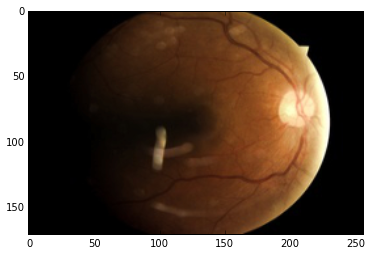

In [55]:
img = cv2.cvtColor(X_test[500].reshape((171,256,3)), cv2.COLOR_HLS2RGB)
plt.imshow(img)
plt.show()